## Part A: CLV Estimation via BYTD and Machine Learning Models

### Summary
This project compares CLV estimation using statistical model (BTYD) and Machine Learning Model (random forest regressor and XGBoost). BTYD performs better in terms of RME and worse than the other two, indicating that predictions from BTYD model have less extreme values. The statistical model requires only customer’s recency, frequency, monetary value, and age of the customers as inputs to estimate CLV of a defined k-period.  

- `customer_id` represents a unique identifier for each customer.
- `frequency` represents the number of *repeat* purchases that a customer has made, i.e. one less than the total number of purchases.
- `T` represents a customer’s “age”, i.e. the duration between a customer’s first purchase and the end of the period of study. In this example notebook, the units of time are in weeks.
- `recency` represents the time period when a customer made their most recent purchase. This is equal to the duration between a customer’s first and last purchase. If a customer has made only 1 purchase, their recency is 0.
- `monetary_value` represents the average value of a given customer’s repeat purchases. Customers who have only made a single purchase have monetary values of zero. 


The machine learning model, on the other hand, require a label, the actual customer spend in the next k-period in the training set. ML model in this project is employed to benchmark BTYD model performance. Another interesting way of using ML model in CLV is through a two-stage learning: 1) classify users based on their likelihood of making a purchase in k period. 2) Estiamte the value of purchases of customers who is predicted to make a purchase. Due to the limitation of the dataset, this project will not consider this method.


After obtaining customers' CLV, I used K-means for customer clustering task. 


**The project answers the following business questions:**
1. Which customers have the highest spend probability in next 6 months? This is used to inform targeted campaign such as sending out email notification. 

2. Which customers were predicted to purchase but didn't? (missed opportunities) Why? 

3. How should the marketing team allocates budget to improve sales?





**These turns into analytical questions:**
* Predict how much a customer will spend in next k period, including the likelihood of 'alive' and the probability of purchasing given 'alive'.
* What is the purchase amount a customer make. 

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotnine as pn

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### I. Data Cleaning and Exploration

1. Join tables to create the transaction data

In [38]:
# dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce 
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_customers = pd.read_csv('data/olist_customers_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')

agg_order_payments = order_payments.groupby('order_id', as_index=False)['payment_value'].sum()
agg_order_items = order_items.groupby('order_id', as_index=False).agg(
    product_count=('product_id', 'count'),
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum')
)

df_transaction = (
    orders
    .merge(order_customers, on='customer_id', how='left')
    .merge(agg_order_payments, on='order_id', how='left')
    .merge(agg_order_items, on='order_id', how='left')
)

df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   customer_unique_id             99441 non-null  object 
 9   customer_zip_code_prefix       99441 non-null  int64  
 10  customer_city                  99441 non-null  object 
 11  customer_state                 99441 non-null  object 
 12  payment_value                  99440 non-null 

In [39]:
# Convert dtypes
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]

df_transaction[date_columns] = df_transaction[date_columns].apply(pd.to_datetime)
 
str_columns = [
    'customer_unique_id', 
    'customer_id', 
    'order_status', 
    'customer_city', 
    'customer_state'
]

df_transaction[str_columns] = df_transaction[str_columns].astype(str)

In [40]:
print(f"First order date: {df_transaction['order_purchase_timestamp'].min()}")
print(f"Most recent order date: {df_transaction['order_purchase_timestamp'].max()}")

First order date: 2016-09-04 21:15:19
Most recent order date: 2018-10-17 17:30:18


In [41]:
print(df_transaction.order_status.unique())

print(df_transaction['order_status'].value_counts(normalize=True))
# 97% of orders are delivered
# cancelled orders rate are pretty low

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']
order_status
delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: proportion, dtype: float64


In [42]:
# filter delivered orders
transaction = df_transaction[df_transaction['order_status'] == 'delivered']

In [43]:
transaction.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,product_count,total_price,total_freight
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,38.71,1.0,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,141.46,1.0,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,179.12,1.0,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,72.20,1.0,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,28.62,1.0,19.90,8.72


In [44]:
# look at the number of orders over time to gauge the usage of the platform
transaction['order_purchase_month'] = transaction['order_purchase_timestamp'].dt.month
transaction['order_purchase_year'] = transaction['order_purchase_timestamp'].dt.year

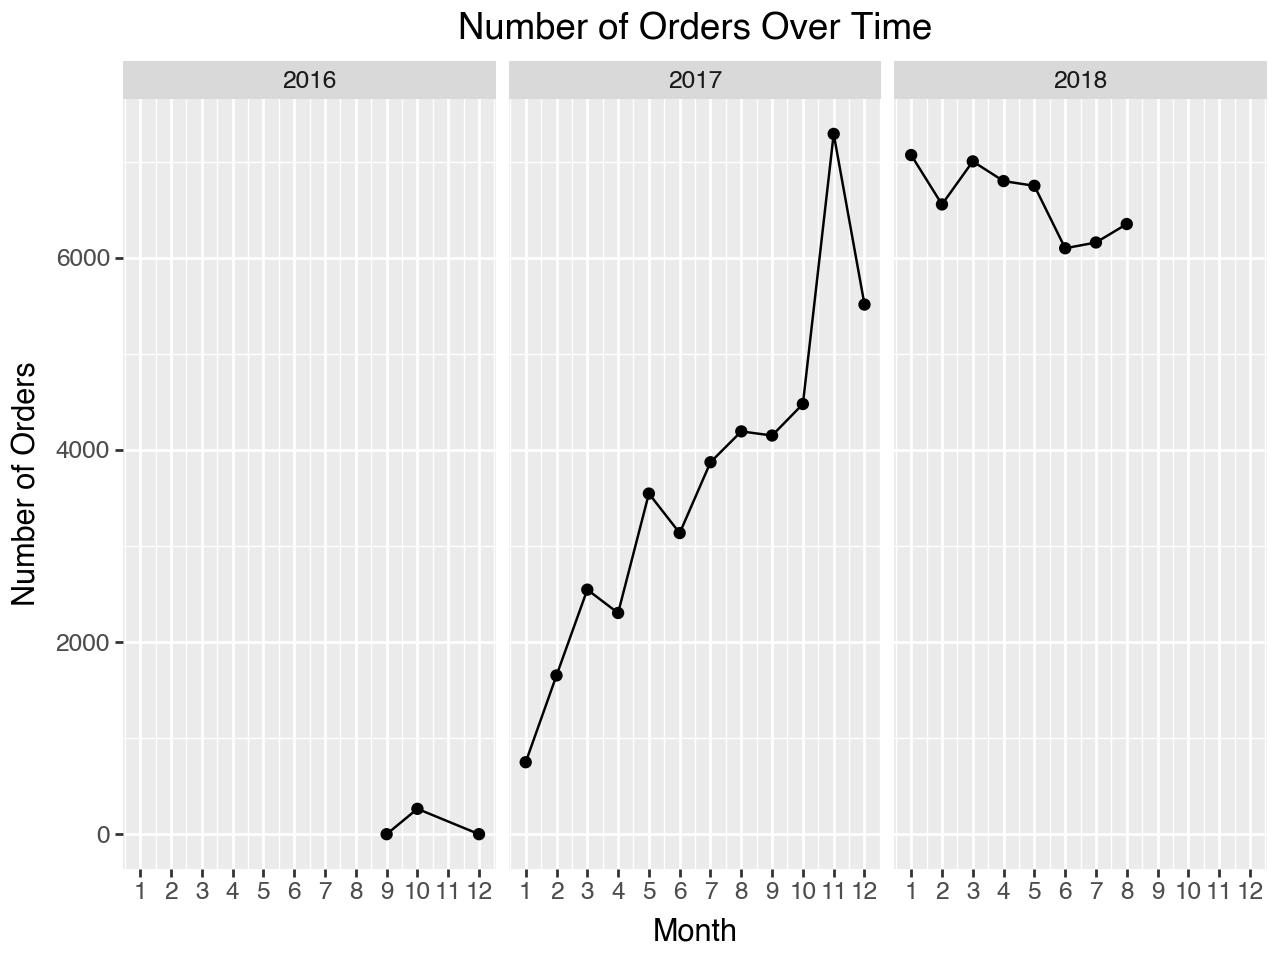

In [45]:
num_orders = transaction.groupby(["order_purchase_year", "order_purchase_month"])[['order_id']].count().reset_index().rename(columns={'order_id': 'order_count'})

pn.ggplot(num_orders, pn.aes(x='order_purchase_month', y='order_count')) + \
    pn.geom_line() + \
    pn.geom_point() + \
    pn.facet_wrap('~order_purchase_year') + \
    pn.scale_x_continuous(breaks=np.arange(1, 13, 1)) + \
    pn.labs(title='Number of Orders Over Time', x='Month', y='Number of Orders', color='Year') 

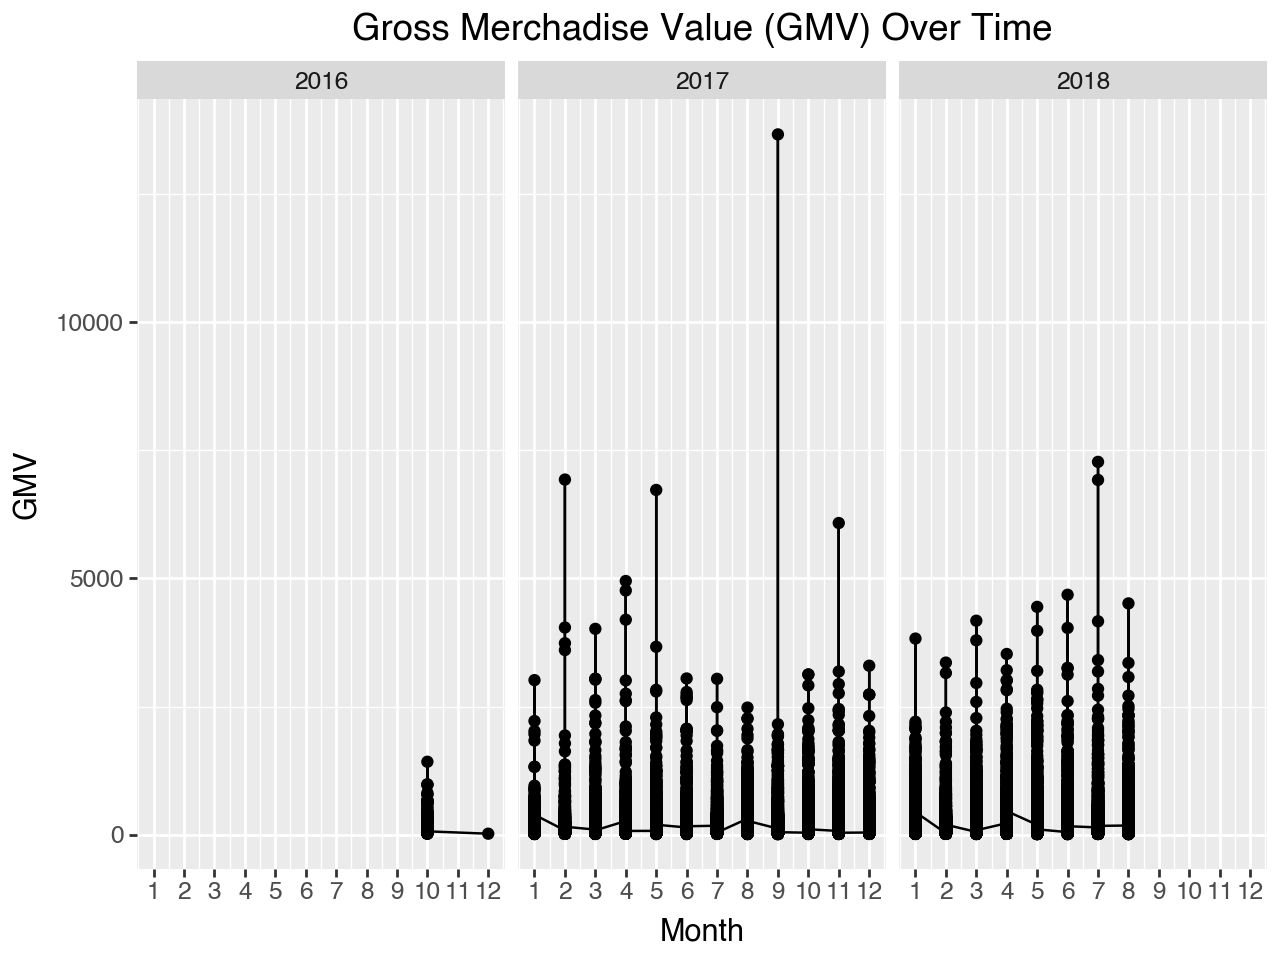

In [46]:
# use plotnine to plot monthly revenue by year using line plot
pn.ggplot(pn.aes(x='order_purchase_month', y='payment_value'), transaction) \
    + pn.geom_line() + pn.geom_point() + pn.facet_wrap('order_purchase_year') \
    + pn.scale_x_continuous(breaks=range(1, 13)) + \
    pn.labs(title='Gross Merchadise Value (GMV) Over Time', x='Month', y='GMV') 

In [47]:
# look at the top 10 customers by revenue and number of orders

top_customers = transaction.groupby('customer_unique_id').agg(
    total_payment=('payment_value', 'sum'),
    total_orders=('order_id', 'nunique')
).sort_values('total_payment', ascending=False).head(10)

top_customers

,total_payment,total_orders
customer_unique_id,,
0a0a92112bd4c708ca5fde585afaa872,13664.08,1
da122df9eeddfedc1dc1f5349a1a690c,7571.63,2
763c8b1c9c68a0229c42c9fc6f662b93,7274.88,1
dc4802a71eae9be1dd28f5d788ceb526,6929.31,1
459bef486812aa25204be022145caa62,6922.21,1
ff4159b92c40ebe40454e3e6a7c35ed6,6726.66,1
4007669dec559734d6f53e029e360987,6081.54,1
eebb5dda148d3893cdaf5b5ca3040ccb,4764.34,1
48e1ac109decbb87765a3eade6854098,4681.78,1


### II. Build BTYD Model to Predict CLV 

The model does two tasks:
1. Predict the probability of being alive
2. Predict the number of purchases in the next k-period. 

$$CLV_{k\space period} = P(Alive | Recency, Frequency) \cdot E[Number \space of \space Purchase | Recency, Frequency] \newline \times E[Value \space of \space Purchase | Frequency, Monetary Value]$$

#### (0). Inputs to the Model
1. Frequency: the number of dates on which a customer made a purchase subsequent to the date of the customer's first purchase
2. Age (T): The number of time units, e.g. days, since the date of a customer's first purchase to the current date (or last date)
3. Recency: the age of the customer at the time of their last purchase
4. Monetary Value: the average per transaction-date spend by a customer during repeat purchases (ignoring the first purchase) [can use other metrics such as Margin]



In [48]:
data = transaction[['order_id', 'order_purchase_timestamp','customer_unique_id', 'payment_value']]
# rename columns
data.columns = ['order_id', 'order_date', 'customer_id', 'revenue']

In [49]:
# create train and test set, use the last 6 months GMV per customer as target to evluated CLV model
n_days = 180 # 6 months CLV preds
max_date = data['order_date'].max()
cutoff = max_date - pd.DateOffset(days=n_days)

train_df = data[data['order_date'] <= cutoff]
test_df = data[data['order_date'] > cutoff]

In [50]:
# use lifetimes liberary to create recency, frequency, and age metrics
from lifetimes.utils import summary_data_from_transaction_data
rft = summary_data_from_transaction_data(train_df, 'customer_id', 'order_date', observation_period_end=train_df.order_date.max()).reset_index()

In [51]:
rft.head()

,customer_id,frequency,recency,T
0,0000f46a3911fa3c0805444483337064,0.0,0.0,357.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,141.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,108.0
3,00053a61a98854899e70ed204dd4bafe,0.0,0.0,2.0
4,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,363.0


In [52]:
# calcualte monetary metrics 
train_df['order_date'] = train_df['order_date'].dt.strftime('%Y-%m-%d')
first_purchase = train_df.groupby('customer_id')[['order_date']].min().reset_index()

# Perform a left merge with an indicator column to identify non-matching rows
merged_df = pd.merge(
    train_df,
    first_purchase,
    on=['customer_id', 'order_date'],
    how='left',
    indicator=True
)

# Filter the rows that are only in train_df
temp = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

temp.head()

,order_id,order_date,customer_id,revenue
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,38.71
10,403b97836b0c04a622354cf531062e5f,2018-01-02,6e26bbeaa107ec34112c64e1ee31c0f5,1376.45
42,6abaad69b8b349c3a529b4b91ce18e46,2018-02-15,fa0ee7ceb94193fb02aa78ce3a55695a,57.00
129,9ceb8ab5165cefecdddb546cb5a6362b,2018-02-05,48625b68a29dcfc3aba4b5147e0625aa,138.09
146,7e3e92dc3eaf5389f32da97228f7dd0e,2017-07-02,ba77e9b6506636dcbd03e463d4786f24,95.21


In [53]:
monetary = temp.groupby('customer_id')['revenue'].mean().reset_index()
rftm = pd.merge(
    rft,
    monetary,
    on='customer_id',
    how='left'
)

# Fill NaN values in the 'revenue' column with 0
rftm['revenue'] = rftm['revenue'].fillna(0)
rftm.rename(columns={'revenue': 'monetary_value'}, inplace=True)

In [54]:
# include only customers that has more than 1 purchase since the model requires at least 2 purchases
rftm_df = rftm[rftm['frequency']>0]

In [55]:
# to validate the model, use the last 6 months of data revenue per customer
test_df = test_df.groupby('customer_id')['revenue'].sum().reset_index()
test_df.head()

,customer_id,revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0004bd2a26a76fe21f786e4fbd80607f,166.98
3,00050ab1314c0e55a6ca13cf7181fecf,35.38
4,0005ef4cd20d2893f0d9fbd94d3c0d97,129.76


In [56]:
# filter only customers that are in the observation period for the test set
test_df = test_df[test_df['customer_id'].isin(rftm_df['customer_id'])]
# rename columns
test_df.columns = ['customer_id', '6-months purchase value'] 

In [57]:
stats_model_data = pd.merge(rftm_df, test_df, on='customer_id', how='left').fillna(0)

In [58]:
stats_model_data.head()

,customer_id,frequency,recency,T,monetary_value,6-months purchase value
0,004288347e5e88a27ded2bb23747066c,1.0,171.0,218.0,103.28,0.0
1,011b4adcd54683b480c4d841250a987f,1.0,177.0,192.0,149.88,0.0
2,013f4353d26bb05dc6652f1269458d8d,1.0,4.0,98.0,164.04,0.0
3,015557c9912277312b9073947804a7ba,1.0,39.0,344.0,72.90,0.0
4,01c289bb06354cdc7e6549570f20ada4,1.0,206.0,272.0,168.36,0.0


In [59]:
# find out the proportion of customers who didn't make any purchase in the next 6 months
no_purchase = stats_model_data[stats_model_data['6-months purchase value'] == 0]
no_purchase_rate = len(no_purchase) / len(stats_model_data)
print(f"Proportion of customers who didn't make any purchase in the next 6 months: {no_purchase_rate:.2f}")

## 94% of the customers didn't make any purchase in the next 6 months

Proportion of customers who didn't make any purchase in the next 6 months: 0.94


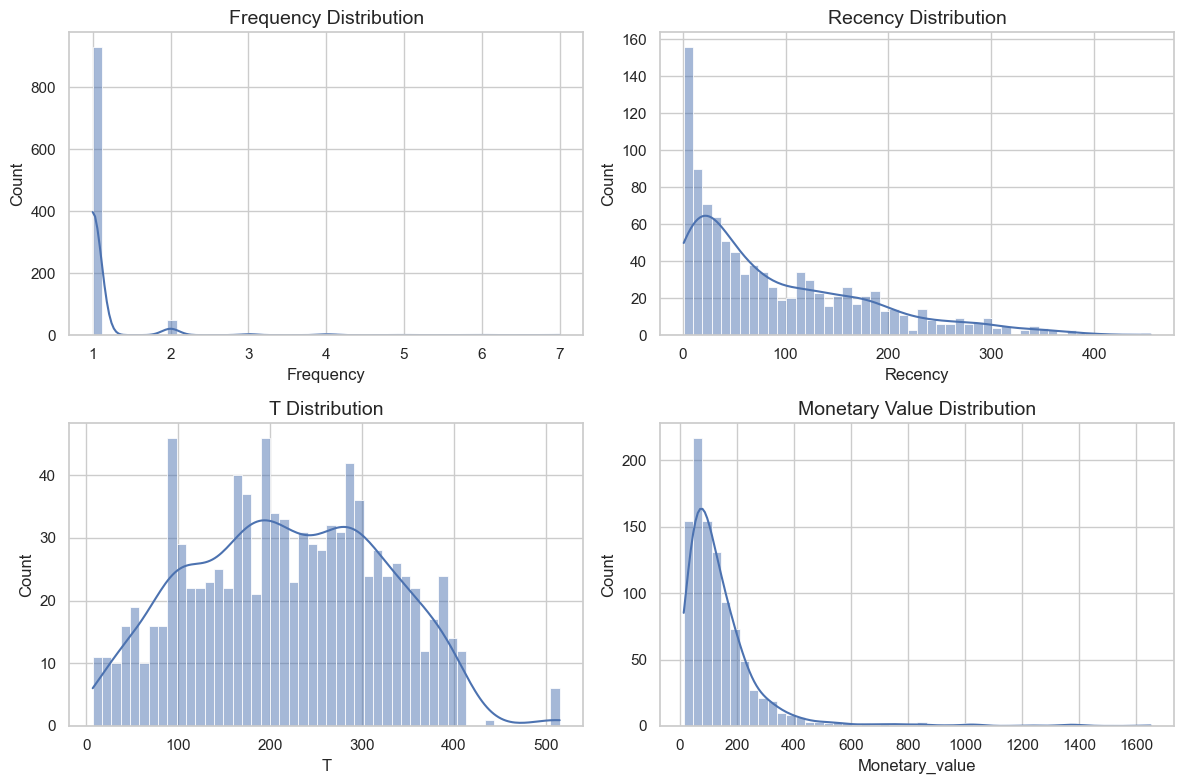

In [60]:
# Adjust the overall style
sns.set(style='whitegrid')  # Use a clean grid style

# Define the column names and corresponding titles
columns = ['frequency', 'recency', 'T', 'monetary_value']
titles = ['Frequency Distribution', 'Recency Distribution', 'T Distribution', 'Monetary Value Distribution']

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Create the subplots

# Loop through the columns to create the plots
for i, col in enumerate(columns):
    sns.histplot(stats_model_data[col], bins=50, ax=ax[i // 2, i % 2], kde=True)
    ax[i // 2, i % 2].set_title(titles[i], fontsize=14)
    ax[i // 2, i % 2].set_xlabel(col.capitalize())
    ax[i // 2, i % 2].set_ylabel('Count')

# Adjust the layout to prevent overlap
plt.tight_layout()

plt.show()


* We have a lot customers who are new to the platform. 
* Most customers have at least 1 repeat purchase. 
* A lot customers are active on the platform.
* A majority of the customers have small purchase

#### (1) Build the Gamma-Gamma Model for Spending Prediction

In [61]:
# Gamma-gamma model assumes that the monetary value is independent of the purchase frequency
# check the condition
returning_customers_summary = stats_model_data
returning_customers_summary[['monetary_value', 'frequency']].corr()

# correlation is close to 0

,monetary_value,frequency
monetary_value,1.00000,0.00166
frequency,0.00166,1.00000


In [62]:
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(stats_model_data['frequency'], stats_model_data['monetary_value'])
print(ggf.summary)
print(ggf)

        coef  se(coef)  lower 95% bound  upper 95% bound
p  10.285109  0.424471         9.453146        11.117072
q   1.363304  0.056882         1.251816         1.474793
v   9.579518  0.432476         8.731865        10.427170
<lifetimes.GammaGammaFitter: fitted with 995 subjects, p: 10.29, q: 1.36, v: 9.58>


In [63]:
rftm_df['avg_spend'] = ggf.conditional_expected_average_profit(rftm_df['frequency'], rftm_df['monetary_value'])
rftm_df.head()

,customer_id,frequency,recency,T,monetary_value,avg_spend
59,004288347e5e88a27ded2bb23747066c,1.0,171.0,218.0,103.28,109.008958
243,011b4adcd54683b480c4d841250a987f,1.0,177.0,192.0,149.88,154.019052
274,013f4353d26bb05dc6652f1269458d8d,1.0,4.0,98.0,164.04,167.695938
292,015557c9912277312b9073947804a7ba,1.0,39.0,344.0,72.90,79.665468
396,01c289bb06354cdc7e6549570f20ada4,1.0,206.0,272.0,168.36,171.868548


#### (2) Build Retention Model

The rention models consists of two parts:
1. Beta-Geometric model to predict pobability of 'alive'
2. Negative Binomial Distribution is sued to estimate the probability of purchase per unit of time. 

In [64]:
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(stats_model_data['frequency'], stats_model_data['recency'], stats_model_data['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.915837,0.040285,0.836878,0.994797
alpha,44.072467,3.528595,37.156421,50.988513
a,0.273598,0.048532,0.178475,0.368721
b,0.029292,0.006437,0.016675,0.041909


*Expected number of future purchases*

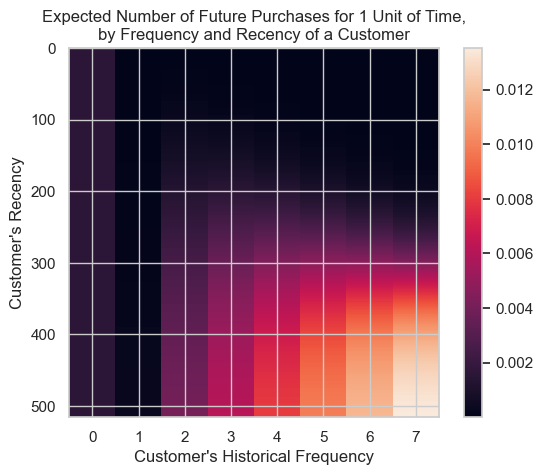

In [65]:
# look a the heatmap of the frequency/recency matrix for expected number of future purchases
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)
plt.show()

# notice that the highest the customer's recency score, the more recent the customer's last purchase.

The heatmap fits inuition. Customers who have a made a lot of purchase and recently made purchase has a higher probability of purchasing the next day (bottom-right), while customers who made a lot purchase but haven't shown up for the longest time probably won't purchase next day(top-right). 

*Probability of Alive*

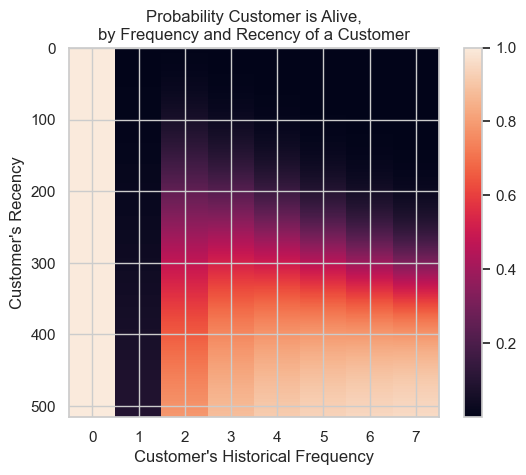

In [66]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)
plt.show()

Customers who purchased a lot and recently purchases are likely still active in the bottom-right corner.

Predict the expected frequencies in the next period (next day).

In [67]:
t = 1 
stats_model_data['predicted_purchases_next_day'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                                           stats_model_data['frequency'], 
                                                                                                           stats_model_data['recency'], 
                                                                                                           stats_model_data['T'])

stats_model_data.sort_values(by='predicted_purchases_next_day').tail(5)

,customer_id,frequency,recency,T,monetary_value,6-months purchase value,predicted_purchases_next_day
794,ca77025e7201e3b30c44b472ff346268,3.0,131.0,144.0,150.590000,381.88,0.017649
395,6469f99c1f9dfae7733b25662e7f1782,4.0,119.0,164.0,126.882000,32.65,0.018168
870,de34b16117594161a6a89c50b289d35a,4.0,75.0,119.0,55.780000,0.00,0.021148
247,3e43e6105506432c953e165fb2acf44c,5.0,162.0,165.0,134.242500,0.00,0.026324
108,1b6c7548a2a1f9037c1fd3ddfed95f33,6.0,93.0,109.0,151.143333,0.00,0.040412


Predict expected live probability

In [68]:
stats_model_data['predicted_alive'] = bgf.conditional_probability_alive(stats_model_data['frequency'], 
                                                                         stats_model_data['recency'], 
                                                                         stats_model_data['T'])
stats_model_data.sort_values(by='predicted_alive').head(5)


,customer_id,frequency,recency,T,monetary_value,6-months purchase value,predicted_purchases_next_day,predicted_alive
969,f7b62c75467e8ce080b201667cbbc274,1.0,1.0,512.0,41.93,0.0,0.000003,0.000868
656,a5d3bfee5b23b430b95c4ae295e1028a,1.0,2.0,405.0,104.30,0.0,0.000006,0.001363
816,cfdaaa0caea59b06efb4b0fb8c700684,1.0,1.0,365.0,115.71,0.0,0.000007,0.001562
981,f9ae226291893fda10af7965268fb7f6,1.0,2.0,358.0,95.67,0.0,0.000008,0.001684
821,d0b2f9c9f13d9048969517d02237b432,1.0,5.0,379.0,36.10,0.0,0.000008,0.001724


#### (3) Estimate CLV for the next 6 months

In [69]:
# calculate the 6-month CLV for each customer
stats_model_data['clv_6mon_stat_model'] = (
  ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    stats_model_data['frequency'],
    stats_model_data['recency'],
    stats_model_data['T'],
    stats_model_data['monetary_value'],
    time=6, # months
    discount_rate=0.007974140428903764 # monthly discount rate (10% annual rate)
  )
)


In [70]:
stats_model_data[['customer_id', 'clv_6mon_stat_model', '6-months purchase value']].head()

,customer_id,clv_6mon_stat_model,6-months purchase value
0,004288347e5e88a27ded2bb23747066c,8.169786,0.0
1,011b4adcd54683b480c4d841250a987f,15.981638,0.0
2,013f4353d26bb05dc6652f1269458d8d,4.135951,0.0
3,015557c9912277312b9073947804a7ba,0.341576,0.0
4,01c289bb06354cdc7e6549570f20ada4,10.213332,0.0


#### (4) Evaluate the model

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the predicted and actual values
predicted = stats_model_data['clv_6mon_stat_model']
actual = stats_model_data['6-months purchase value']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual, predicted, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 23.60
Root Mean Squared Error (RMSE): 83.81


In [72]:
print(f'True 6-month average purchase value: {stats_model_data['6-months purchase value'].mean()}')
print(f'Predicted 6-month average purchase value: {stats_model_data['clv_6mon_stat_model'].mean()}')

# The model does a decent job on aggregate level

True 6-month average purchase value: 10.470613065326633
Predicted 6-month average purchase value: 17.5556799632356


### II. Machine Learning Model with Only RFM metrics

#### (1) Baseline Method

In [73]:
# to enable performance compare with the ML model, we set aside 30% of the test data 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    stats_model_data[['frequency', 'recency', 'T', 'monetary_value']], 
    stats_model_data['6-months purchase value'], test_size=0.2, random_state=0)


In [74]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=0)
model = rf_reg.fit(X_train, y_train)

rf_reg_pred = model.predict(X_test)

In [75]:
rmse_rf_reg = mean_squared_error(y_test, rf_reg_pred, squared=False)
mae_rf_reg = mean_absolute_error(y_test, rf_reg_pred)

print(f"Mean Absolute Error (MAE): {mae_rf_reg:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_reg:.2f}")

Mean Absolute Error (MAE): 21.68
Root Mean Squared Error (RMSE): 103.86


In [76]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

def train_and_predict_xgb(X_train, y_train, X_test, param_grid, cv=5, random_state=42):
    # initialize XGBRegressor with specified parameters
    xgb_spec = XGBRegressor(
        objective="reg:pseudohubererror",
        random_state=random_state
    )

    # set up GridSearchCV
    xgb_model = GridSearchCV(
        estimator=xgb_spec,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        refit=True,
        cv=cv
    )

    # fit the model on the training data
    xgb_model.fit(X_train, y_train)
    
    # make predictions on the test data
    predictions = xgb_model.predict(X_test)
    
    xgb_mse = mean_squared_error(y_test, predictions, squared=False)
    xgb_mae = mean_absolute_error(y_test, predictions)
    # return the best model and the predictions
    return xgb_model.best_estimator_, xgb_mse, xgb_mae

param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
}

# Call the function with your training data, test data, and parameter grid
best_model, xgb_mse, xgb_mae = train_and_predict_xgb(X_train, y_train, X_test, param_grid)

In [77]:
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {xgb_mse:.2f}")

Mean Absolute Error (MAE): 12.72
Root Mean Squared Error (RMSE): 102.08


In [78]:
# create a data to represent the performance of the models
model_performance = pd.DataFrame({
    'Model': ['Statistical Model', 'Random Forest One Step Method', 'XGBoost One Step Method'],
    'MAE': [mae, mae_rf_reg, xgb_mae],
    'RMSE': [rmse, rmse_rf_reg, xgb_mse]
})


In [79]:
model_performance

,Model,MAE,RMSE
0,Statistical Model,23.603820,83.812922
1,Random Forest One Step Method,21.681961,103.855791
2,XGBoost One Step Method,12.715545,102.083750


Statistical model performs the best, exceeding both Random Forest and XGBoost in RMSE score. In terms of MAE XGBoost performs the best. This suggests that the statistical model's estimation does not result in extreme predictiosn as in the case of the other two. 

## Step 2: Customer Segementation for Targeted Marketing Campaigns

Now we will utilize the entire dataset to predict CLV, based on which segment customers for targeted marketing campaigns. 

In [80]:
# create a function to create rftm data

def convert_rftm(transaction_date):
    transaction_date['order_date'] = transaction_date['order_date'].dt.strftime('%Y-%m-%d')
    rft = summary_data_from_transaction_data(train_df, 'customer_id', 'order_date', observation_period_end=transaction_date['order_date'].max()).reset_index()
    first_purchase = transaction_date.groupby('customer_id')[['order_date']].min().reset_index()
    merged_df = pd.merge(
        transaction_date,
        first_purchase,
        on=['customer_id', 'order_date'],
        how='left',
        indicator=True
    )
    temp = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')
    monetary = temp.groupby('customer_id')['revenue'].mean().reset_index()
    rftm = pd.merge(
        rft,
        monetary,
        on='customer_id',
        how='left'
    )
    rftm['revenue'] = rftm['revenue'].fillna(0)
    rftm.rename(columns={'revenue': 'monetary_value'}, inplace=True)
    rftm_df = rftm[rftm['frequency']>0]
    return rftm_df

In [81]:
def compute_clv_stats_model(rftm_data, bgf_penalizer=0.1, ggf_penalizer=0.001, monthly_discount_rate=0.007974140428903764, pred_time=12):
    # Fit the BG/NBD model
    bgf = BetaGeoFitter(penalizer_coef=bgf_penalizer)
    bgf.fit(rftm_data['frequency'], rftm_data['recency'], rftm_data['T'])

    # Fit the Gamma-Gamma model
    ggf = GammaGammaFitter(penalizer_coef=ggf_penalizer)
    ggf.fit(rftm_data['frequency'], rftm_data['monetary_value'])
    
    # Compute the k-month CLV
    rftm_data[f'clv_{pred_time}'] = ggf.customer_lifetime_value(
        bgf, #the model to use to predict the number of future transactions
        rftm_data['frequency'],
        rftm_data['recency'],
        rftm_data['T'],
        rftm_data['monetary_value'],
        time=pred_time, # months
        discount_rate=monthly_discount_rate # monthly discount rate
    )

    return rftm_data

In [82]:
all_rftm = convert_rftm(data)

In [83]:
all_rftm_data = compute_clv_stats_model(all_rftm)

In [84]:
all_rftm_data.head()

,customer_id,frequency,recency,T,monetary_value,clv_12
59,004288347e5e88a27ded2bb23747066c,1.0,171.0,398.0,103.28,2.428821
243,011b4adcd54683b480c4d841250a987f,1.0,177.0,372.0,149.88,4.257211
274,013f4353d26bb05dc6652f1269458d8d,1.0,4.0,278.0,164.04,0.494246
292,015557c9912277312b9073947804a7ba,1.0,39.0,524.0,72.90,0.144167
396,01c289bb06354cdc7e6549570f20ada4,1.0,206.0,452.0,168.36,3.719917


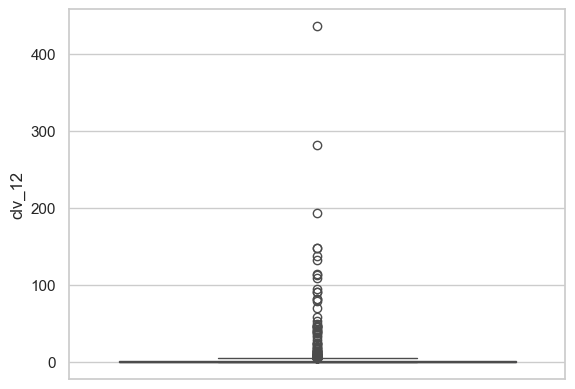

In [85]:
# plot boxplot of clv_12
sns.boxplot(all_rftm_data['clv_12'])
plt.show()


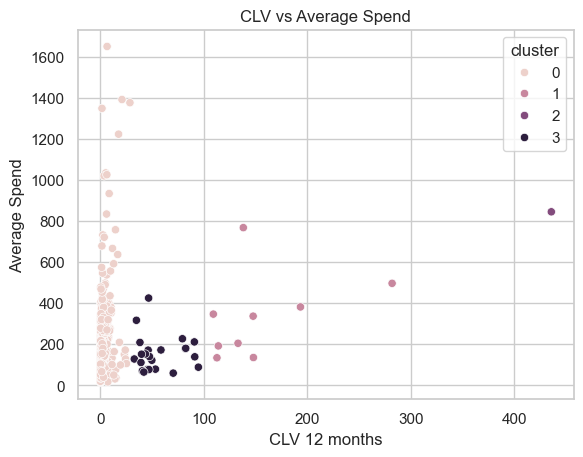

In [86]:
# employ k-mean clustering to segment customers based on their CLV

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X = all_rftm_data[['clv_12']]
X_scaled = scaler.fit_transform(X)

# Fit KMeans and predict cluster labels
kmeans = KMeans(n_clusters=4, random_state=0)
all_rftm_data['cluster'] = kmeans.fit_predict(X_scaled)

# Plot the clusters
sns.scatterplot(data=all_rftm_data, x='clv_12', y='monetary_value', hue='cluster')
plt.xlabel('CLV 12 months')
plt.ylabel('Average Spend')
plt.title('CLV vs Average Spend')
plt.show()

In [87]:
all_rftm_data.head()

,customer_id,frequency,recency,T,monetary_value,clv_12,cluster
59,004288347e5e88a27ded2bb23747066c,1.0,171.0,398.0,103.28,2.428821,0
243,011b4adcd54683b480c4d841250a987f,1.0,177.0,372.0,149.88,4.257211,0
274,013f4353d26bb05dc6652f1269458d8d,1.0,4.0,278.0,164.04,0.494246,0
292,015557c9912277312b9073947804a7ba,1.0,39.0,524.0,72.90,0.144167,0
396,01c289bb06354cdc7e6549570f20ada4,1.0,206.0,452.0,168.36,3.719917,0


In [88]:
# calculate the total clv and average clv for each cluster
clv_summary = all_rftm_data.groupby('cluster').agg(
    total_clv=('clv_12', 'sum'),
    avg_clv=('clv_12', 'mean')
).reset_index()

clv_summary

,cluster,total_clv,avg_clv
0,0,1714.798770,1.782535
1,1,1378.353812,153.150424
2,2,436.040143,436.040143
3,3,1296.255353,56.358928


The marketing team can utilize this data to perform targeted campaigns. Further analysis includes:
1. Find out what channels lead customers to the site
2. Analyze behavioral and demographic data to understand customers' perference. 
3. Cluster customers based on their preference and recommond bundle products to uplift sales. 
4. Analyze customer search data and seller product data to ensure both end meets. 